In [11]:
import math
import numpy as np
import matplotlib.pyplot as plt 
from fenics import *
from dolfin import *
from mshr import *

In [16]:
# We should find another way to save the data, maybe through DGL

def save_state(f, x0, xn, nx, y0, yn, ny):
    state = np.empty((nx, ny))
    for i in range(nx):
        for j in range(ny):
            state[i, j] = f(x0 + i*(xn-x0)/nx, y0 + j*(yn-y0)/ny)
    return state

## Wave equation from a source point

We want to solve the following equation:
$$
\frac{\partial^2 u}{\partial t^2} = c^2 \left( \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} \right)
$$
where $c$ is the propagation speed of the wave.

The _weak forms_ of the equations are derived to be used with Finite Element methods (See the forum [here](https://fenicsproject.org/qa/8883/wave-propagation-from-a-source-point/) )

### Problem Setup

In [12]:
# Mesh Generation
c=5000
mesh = Rectangle(Point(-2., -2.),Point(2., 2.))
mesh = generate_mesh(mesh, 80)
V=FunctionSpace(mesh, "Lagrange", 1)

# Time variables
dt = 0.000004; t = 0; T = 0.004

# Previous and current solution
u1= interpolate(Constant(0.0), V)
u0= interpolate(Constant(0.0), V)

# Variational problem at each time
u = TrialFunction(V)
v = TestFunction(V)

a = u*v*dx + dt*dt*c*c*inner(grad(u), grad(v))*dx
L = 2*u1*v*dx-u0*v*dx

bc = DirichletBC(V, 0, "on_boundary")
A, b = assemble_system(a, L, bc)

u=Function(V)

### Solving

In [13]:
data = []

while t <= T:
    A, b = assemble_system(a, L, bc)
    delta = PointSource(V, Point(-2.0, 0), sin(c * 10 * t))
    delta.apply(b)
    solve(A, u.vector(), b)
    u0.assign(u1)
    u1.assign(u)
    t += dt
    print('Time {:.6f}/{:.6f}s'.format(t, T), end='\r')
    
    # Reduce the range of the solution so that we can see the waves
    j = 0
    for i in u.vector():
        i = min(.01, i)
        i = max(-.01, i)
        u.vector()[j] = i;
        j += 1
    
    # Save data
    data.append(save_state(u, -2, 2, 80, -2, 2, 80))

### Plotting

In [14]:
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

fig, ax = plt.subplots()

# We get maximum and minimum values of the data for plotting
vmax = 0
vmin = 0
for d in data:
    top = d.max()
    bottom = d.min()
    if vmax < top:
        vmax = top
    if vmin > bottom:
        vmin = bottom

im = ax.matshow(data[0], vmin=vmin, vmax=vmax)
plt.close()

# Initialization function: plot the background of each frame
def init():
    im.set_data(data[0])
    return im,

# Animation function which updates figure data.  This is called sequentially
def update(i):
    im.set_data(data[i])
    return im,

# Call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, update, frames=1000, init_func = init,
                               interval=20, blit=False)

# Call function to display the animation
HTML(anim.to_html5_video())

## Wave equation and interference
We use the same equations as above with two sources

In [74]:
# Mesh Generation
c=5000
mesh = Rectangle(Point(-2., -2.),Point(2., 2.))
mesh = generate_mesh(mesh, 80)
V=FunctionSpace(mesh, "Lagrange", 1)

# Time variables
dt = 0.000004; t = 0; T = 0.004

# Previous and current solution
u1= interpolate(Constant(0.0), V)
u0= interpolate(Constant(0.0), V)

# Variational problem at each time
u = TrialFunction(V)
v = TestFunction(V)

a = u*v*dx + dt*dt*c*c*inner(grad(u), grad(v))*dx
L = 2*u1*v*dx-u0*v*dx

bc = DirichletBC(V, 0, "on_boundary")
A, b = assemble_system(a, L, bc)

u=Function(V)

In [75]:
data = []

while t <= T:
    A, b = assemble_system(a, L, bc)
    delta1 = PointSource(V, Point(-2, -0.7), sin(c * 10 * t))
    delta1.apply(b)
    delta2 = PointSource(V, Point(-2, 0.7), sin(c * 10 * t))
    delta2.apply(b)
    solve(A, u.vector(), b)
    u0.assign(u1)
    u1.assign(u)
    t += dt
    print('Time {:.6f}/{:.6f}s'.format(t, T), end='\r')
    
    # Reduce the range of the solution so that we can see the waves
    j = 0
    for i in u.vector():
        i = min(.01, i)
        i = max(-.01, i)
        u.vector()[j] = i;
        j += 1
    
    # Save data
    data.append(save_state(u, -2, 2, 80, -2, 2, 80))

In [76]:
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

fig, ax = plt.subplots()

# We get maximum and minimum values of the data for plotting
vmax = 0
vmin = 0
for d in data:
    top = d.max()
    bottom = d.min()
    if vmax < top:
        vmax = top
    if vmin > bottom:
        vmin = bottom

im = ax.matshow(data[0], vmin=vmin, vmax=vmax)
plt.close()

# Initialization function: plot the background of each frame
def init():
    im.set_data(data[0])
    return im,

# Animation function which updates figure data.  This is called sequentially
def update(i):
    im.set_data(data[i])
    return im,

# Call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, update, frames=len(data), init_func = init,
                               interval=20, blit=False)

# Call function to display the animation
HTML(anim.to_html5_video())

## Self-interference

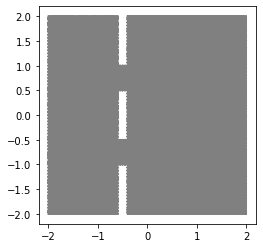

In [29]:
# Mesh Generation
c=5000
total_area = Rectangle(Point(-2., -2.),Point(2., 2.))
barrier_down = Rectangle(Point(-0.6, -2.),Point(-0.4, -1.))
barrier_center = Rectangle(Point(-0.6, -0.5),Point(-0.4, 0.5))
barrier_up = Rectangle(Point(-0.6, 1.),Point(-0.4, 2.))
mesh = total_area - barrier_down - barrier_center - barrier_up
mesh = generate_mesh(mesh, 80)
V=FunctionSpace(mesh, "Lagrange", 1)
plot(mesh)

In [58]:
# Time variables
dt = 0.000004; t = 0; T = 0.004

# Previous and current solution
u1= interpolate(Constant(0.0), V)
u0= interpolate(Constant(0.0), V)

# Variational problem at each time
u = TrialFunction(V)
v = TestFunction(V)

a = u*v*dx + dt*dt*c*c*inner(grad(u), grad(v))*dx
L = 2*u1*v*dx-u0*v*dx

bc = DirichletBC(V, 0, "on_boundary")
A, b = assemble_system(a, L, bc)

u=Function(V)

In [59]:
while t <= T:
    A, b = assemble_system(a, L, bc)
    delta = PointSource(V, Point(-2.0, 0), sin(c * 10 * t))
    delta.apply(b)
    solve(A, u.vector(), b)
    u0.assign(u1)
    u1.assign(u)
    t += dt
    print('Time {:.6f}/{:.6f}s'.format(t, T), end='\r')
    
    # Reduce the range of the solution so that we can see the waves
    j = 0
    for i in u.vector():
        i = min(.01, i)
        i = max(-.01, i)
        u.vector()[j] = i;
        j += 1

# Not working!!
# Save data
#     data.append(save_state(u, -2, 2, 80, -2, 2, 80))


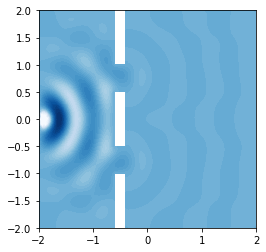

In [62]:
plot(u, cmap='Blues')

## Note
Need to save data under another format for later use